Prepare dataset

In [4]:
# Dataset load
import pandas as pd
data = pd.read_csv('dataset/haberman.csv')
# Dataset split into trainset testset 5:1 ratio
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(data,test_size=0.2,random_state=1234, shuffle=True)


In [5]:
# Splitting into x_train, y_train, x_test, y_test 
# Changing class value from 1, 2 to 0, 1
x_train, y_train = [], []

for i in range(len(trainset)):
    x_train.append(list(trainset.iloc[i, 0:3]))
    y_train.append(list(trainset.iloc[i, 3:4])[0])

x_test, y_test = [], []

for i in range(len(testset)):
    x_test.append(list(testset.iloc[i, 0:3]))
    y_test.append(list(testset.iloc[i, 3:4])[0])
    
for i in range(len(y_train)):
    if y_train[i] == 2:
        y_train[i] = 1
    else:
        y_train[i] = 0
for i in range(len(y_test)):
    if y_test[i] == 2:
        y_test[i] = 1
    else:
        y_test[i] = 0

In [6]:
# Data scaling with MaxAbsScaler
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Import

In [10]:

import matplotlib.pyplot as plt
import numpy as np

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap

from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms import QSVC


In [8]:
from qiskit import BasicAer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import algorithm_globals
from qiskit_aer import AerSimulator

from qiskit_ionq import IonQProvider
IBMQ.load_account()

# provider = IonQProvider() # put token inside IonQProvider(
provider = IBMQ.get_provider(hub='ibm-q-skku', group='snu', project='snu-students') # put your hub, groups, project in IBMQ.get_provider()
algorithm_globals.random_seed = 1234 

In [246]:
# backend = BasicAer.get_backend("statevector_simulator")
# backend = provider.get_backend("ionq_simulator") # ionq simulator backend, you can also use ionq_qpu
backend = AerSimulator.from_backend(provider.get_backend('ibm_sherbrooke')) # AerSimulator from real backend, you can use any real machine from IBM, 
                                                                              # We picked ibm_sherbrooke because it is one of the best machines in IBM

In [247]:
# Define QuantumInstance, feature_map, QuantumKernel and Run QSVM
qi = QuantumInstance(
    backend = backend ,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
    shots = 1024
)
feature_map = ZZFeatureMap(feature_dimension= 3, reps=4, entanglement='full')
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi)

qsvc = QSVC(quantum_kernel=qkernel, probability = False, C= 1e5, gamma = 1e2)
qsvc.fit(np.array(x_train_scaled), np.array(y_train))                           
y_hat = qsvc.predict(x_test_scaled)                                              
y_hat.mean(), np.array(y_train).mean(), np.array(y_test).mean()     

(0.14516129032258066, 0.2459016393442623, 0.3387096774193548)

In [249]:
# Print Accuracy, Precision, Recall, F1-Score of predicted labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy : %.4f" % accuracy_score(y_test,y_hat))
print("precision : %.4f" % precision_score(y_test, y_hat))
print("recall : %.4f" % recall_score(y_test, y_hat))
print("F1-Score : %.4f" % f1_score(y_test, y_hat))

accuracy : 0.6774
precision : 0.5556
recall : 0.2381
F1-Score : 0.3333


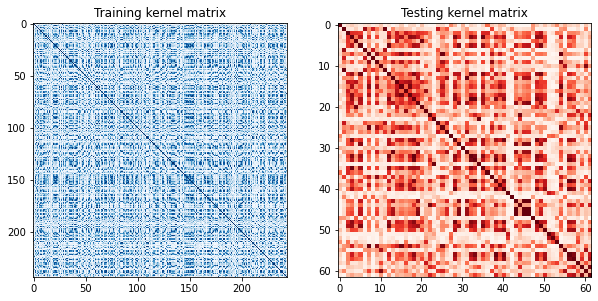

In [236]:
# Plot Kernel matrix from   
matrix_train = qkernel.evaluate(x_vec=x_train_scaled)
matrix_test = qkernel.evaluate(x_vec=x_test_scaled)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()

Using Dynamical Decoupling for error correction in feature_map circuit

In [127]:
from qiskit.circuit.library import XGate, YGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
backend = AerSimulator.from_backend(provider.get_backend('ibm_sherbrooke'))
durations = InstructionDurations.from_backend(backend)
# dd_sequence = [XGate(), XGate()]
# spacing = [1/4, 1/2, 1/4]
dd_sequence = [XGate(), YGate(), XGate(), YGate()]
spacing = [0, 1/4, 1/4, 1/4, 1/4]
constraints = backend.configuration().timing_constraints

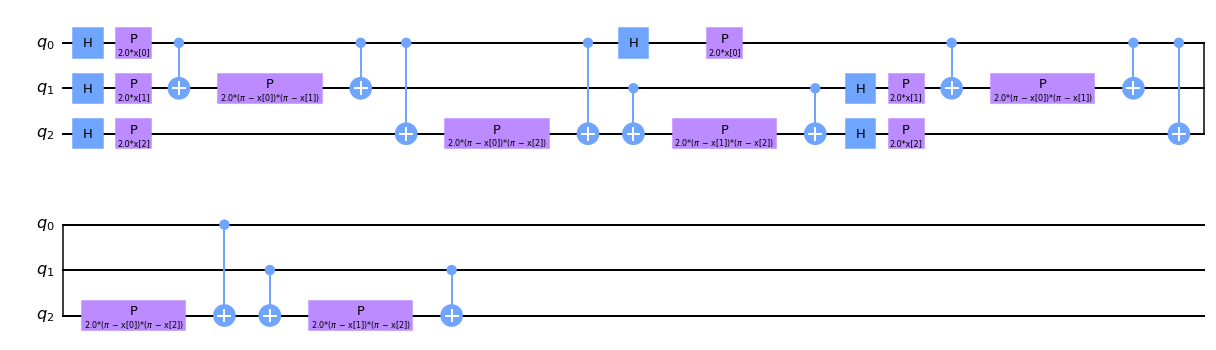

In [128]:
from qiskit.transpiler import PassManager, InstructionDurations
feature_map = ZZFeatureMap(feature_dimension= 3, reps=2, entanglement='full').decompose()
properties = backend.properties()
feature_map.draw('mpl')

Since  H, P, cx is not basis we have to get their gate_length from transpiled circuits below

256


C:\Users\c5517\AppData\Local\Temp\ipykernel_25288\3975180453.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


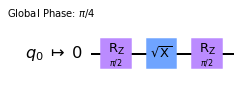

In [143]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.h(0)
tc_h = transpile(circ, backend = backend)
length_h = 0
for gate in tc_h:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_h += length
length_h = round(length_h * 9/2 * 1e9) # convert second to dt unit
print(length_h)
tc_h.draw('mpl', idle_wires=False)

0


C:\Users\c5517\AppData\Local\Temp\ipykernel_25288\1101335189.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


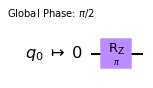

In [144]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.p(np.pi, 0)
tc_p = transpile(circ, backend = backend)
length_p = 0
for gate in tc_p:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_p += length
length_p = round(length_p * 9/2 * 1e9) # convert second to dt unit
print(length_p)
tc_p.draw('mpl', idle_wires=False)

3424


C:\Users\c5517\AppData\Local\Temp\ipykernel_25288\400603484.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


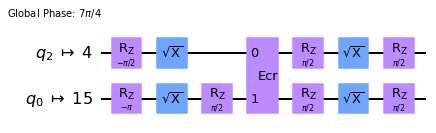

In [145]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.cx(0,2)
tc_p = transpile(circ, backend = backend)
length_cx = 0
for gate in tc_p:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_cx += length
length_cx = round(length_cx * 9/2 * 1e9) # convert second to dt unit
print(length_cx)
tc_p.draw('mpl', idle_wires=False)

256


C:\Users\c5517\AppData\Local\Temp\ipykernel_25288\78025820.py:8: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


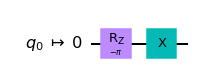

In [146]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
circ = QuantumCircuit(3,3)
circ.y(0)
tc_y = transpile(circ, backend = backend)
length_y = 0
for gate in tc_y:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    length = properties.gate_length(str(name), qubit)
    length_y += length
length_y = round(length_y * 9/2 * 1e9) # convert second to dt unit
print(length_y)
tc_y.draw('mpl', idle_wires=False)

In [147]:
for gate in feature_map:
    qubit = [gate[1][i].index for i in range(len(gate[1]))]
    name = gate[0].name
    if gate[0] in backend._basis_gates():
        length = properties.get_length(str(name), qubit)
    elif name == 'cx':
         length = length_cx
    elif name == 'p':
        length = length_p
    elif name == 'h':
        length = length_h
    durations.update(InstructionDurations([(str(name), qubit, length)]))
for i in range(3):
    durations.update(InstructionDurations([('y', i, length_y)]))
pm = PassManager([ALAPScheduleAnalysis(durations),
                  PadDynamicalDecoupling(durations, dd_sequence, spacing=spacing,
                                         pulse_alignment=constraints['pulse_alignment'])])

C:\Users\c5517\AppData\Local\Temp\ipykernel_25288\4192881195.py:2: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubit = [gate[1][i].index for i in range(len(gate[1]))]


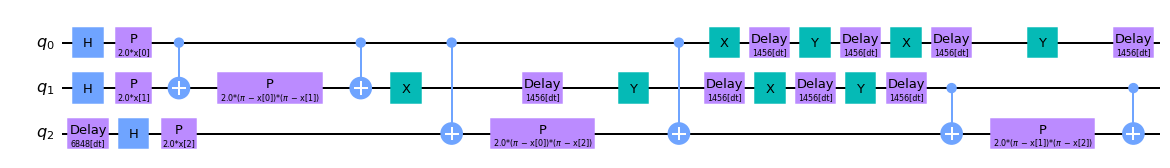

In [253]:
# pass feature_map into pass manger to apply dynamical decoupling sequence
feature_map = pm.run(ZZFeatureMap(feature_dimension= 3, reps=1, entanglement='full').decompose())
feature_map.draw('mpl', fold = 100)

Now we can run QSVM with feature_map which has dd sequence in it

In [ ]:
# Define QuantumInstance, feature_map, QuantumKernel and Run QSVM
qi = QuantumInstance(
    backend = backend ,
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
    shots = 1024
)
feature_map = pm.run(ZZFeatureMap(feature_dimension= 3, reps=2, entanglement='full').decompose())
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=qi)

qsvc = QSVC(quantum_kernel=qkernel, probability = False, C = 1e5, gamma = 1e2/2) # C, gamma values are hyperparameters for SVM, probability = True for getting Roc-Auc curve but in default False for reducing training time
qsvc.fit(np.array(x_train_scaled), np.array(y_train))                            # Fitting train data
y_hat = qsvc.predict(x_test_scaled)                                              # Predicting test data
y_hat.mean(), np.array(y_train).mean(), np.array(y_test).mean()     

In [259]:
# Print Accuracy, Precision, Recall, F1-Score of predicted labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("accuracy : %.4f" % accuracy_score(y_test,y_hat))
print("precision : %.4f" % precision_score(y_test, y_hat))
print("recall : %.4f" % recall_score(y_test, y_hat))
print("F1-Score : %.4f" % f1_score(y_test, y_hat))

accuracy : 0.5161
precision : 0.2353
recall : 0.1905
F1-Score : 0.2105
